# LSTM Neural Network for Time Series Prediction

## 1. Introduction

### 1. 1 Recurrent Neural Networks (RNNs)
Learning from persisted information - Understanding from previous state 
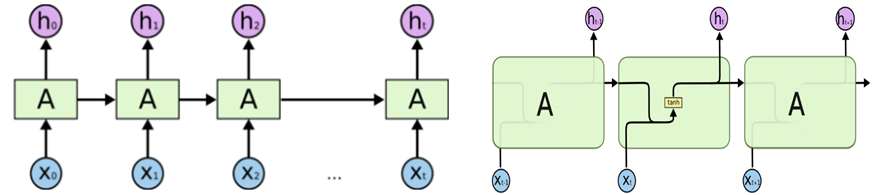

1. Module A gets input Xi and a looped information from previous modules in the network
2. Module A is a repeating one througout the network
3. These networks operate on sequences of vectors: sequences in the input, the output, or both


### 1.2  Long Short Term Memory Networks (LSTM)
1. RNNs fail to handle long term dependencies
2. In RNN the repeating module A usually has a simple structure consisting of a single layer
3. LSTMs are designed to remember information for longer periods
4. In LSTM the repeating module consists of four interacting layers

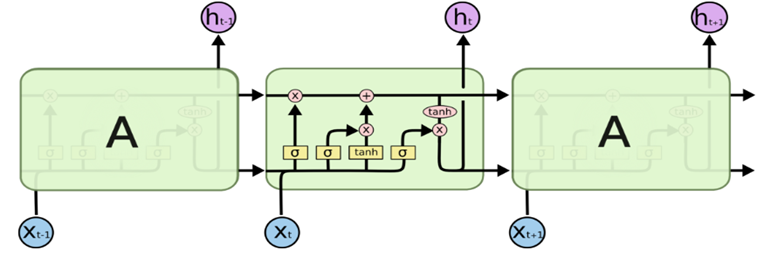

The first step in LSTM is to decide what information has to be thrown away from the cell state. This decision is made by a sigmoid layer called the “forget gate layer.” It looks at ht−1 and xt, and outputs a number between 0 and 1 for each number in the cell state Ct−1. A 1 represents “completely keep this” while a 0 represents “completely get rid of this.”

The next step is to decide what new information is going to be stored in the cell state. This has two parts. First, a sigmoid layer called the “input gate layer” decides which values are to be updated. Next, a tanh layer creates a vector of new candidate values, ~Ct, that could be added to the state. In the next step, these two would be combined to create an update to the state.
It’s now time to update the old cell state, Ct−1, into the new cell state Ct. The previous steps already decided what to do, it  just needs to be actually done.

The old state is multiplied by ft, forgetting the things that were decided to forget earlier. Then add it∗~Ct. This is the new candidate values, scaled by how much is decided to update each state value.

Finally, what is being output has to be decided. This output will be based on the cell state, but will be a filtered version. First, the sigmoid layer is run which decides what parts of the cell state are going to be output. Then, the cell state is put through tanhtanh (to push the values to be between −1 and 1) and multiply it by the output of the sigmoid gate, so that the required parts are to be output.

LSTM Ref: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

### 1.3 About the Dataset

To illustarte how the Long Short Term memory networks works, the standard sin wave function data is used 

The simulated dataset from sine function consists of N previous values of the y=sin(t),  where y is the observed amplitude signal at time t

The probelm is to predict M values of y for the corresponding future time points

The approach of using LSTM model on sinusoidal data can be applied on some real world internet-of-things (IOT) use cases. One such example is to predict the daily output of a solar panel based on the initial readings of the day.
 

### 1.4 Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


### 1.5 User Defined Functions

In [28]:
# Function to train the models

def train_model(model,X, y, epoch_count, batch):
    start = time.time()
    hist = model.fit(X,y,batch_size=batch,nb_epoch=epoch_count, validation_split=0.1)
    print("> Train Time : ", time.time() - start)
    return hist

In [3]:
# Function to plot the training and validation loss
def plot_error_graph(hist, graph_title):
    plt.plot(hist.history['loss'], linewidth=3, label='train loss')
    plt.plot(hist.history['val_loss'], linewidth=3, label='valid loss')
    plt.grid()
    plt.title(graph_title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.yscale('log')
    plt.legend()
    plt.show() 

In [4]:
#Function to plot the actuals vs. predicted graph
def plot_actuals_to_predition(actual_data, predicted):
    plt.plot(actual_data)
    plt.plot(predicted)
    plt.show()

In [5]:
#Function to plot grpah
def plot_data(values):
    plt.figure(figsize=(20,6))
    plt.plot(values)
    plt.show()
    

In [27]:
# Function to create LStM models
# Here we create a two layer LSTM model
def create_model():
    model = Sequential()
    model.add(LSTM(input_shape = (50,1), output_dim= 50, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(LSTM(256))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation("linear"))
    model.compile(loss="mse", optimizer="adam")
    
    return model

## 2. Load and Prepare the data

In [6]:
# The data in .csv format is loaded using the pandas read_csv command. 
series =  pd.read_csv('sine-wave.csv', header=None )

In [7]:
# Check the first 4 rows in the dataframe
series.head(4)

,0
0,0.841471
1,0.873736
2,0.902554
3,0.927809


In [62]:
# Check the data shape to see how the data is organized
series.shape

(4951, 51)

#### Visualizing the data

Lets see how the data is by plotting a graph

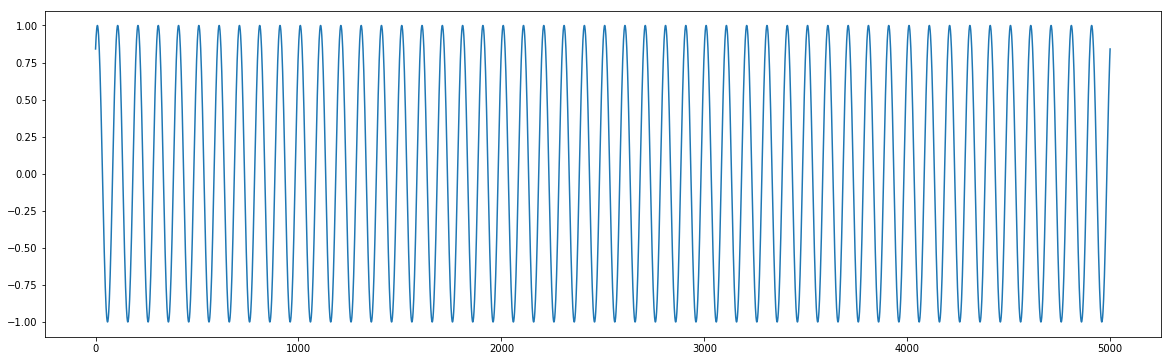

In [9]:
plot_data(series.values)

#### Identifying the partial plot with 50 time steps
Let us plot the data with using 50 data points and see the shape

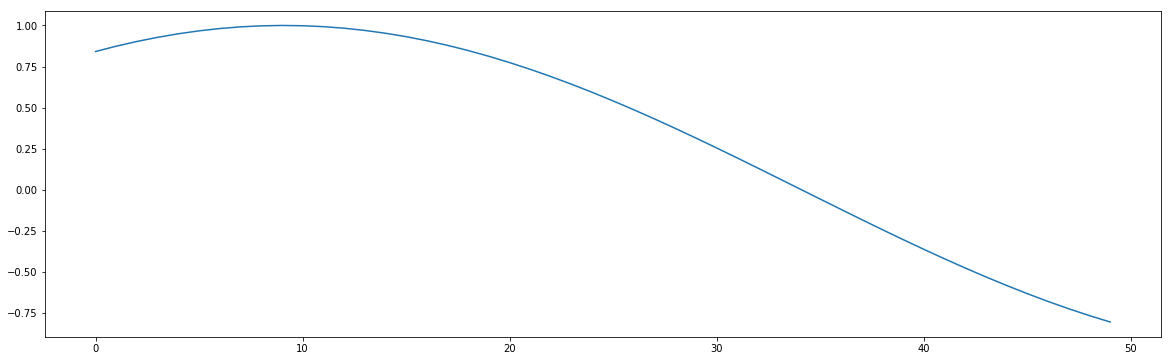

In [10]:
plot_data(series.values[:50])

Since the sine wave data ranges between +1 and -1, it is not required to normalize this data. But this step may be required for certain data sets where the data elements are not bounded within a range

In [11]:
# normalize features 
# In this case it may not be required as the sine wave data is still in -1 to 1 range. 
#But for other datasets its helps to normalize

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(series.values)
series = pd.DataFrame(scaled)

Creating a window for features with a window size of 50 and using the 51st time series point as the output to be predicted

In [12]:
# Drop rows which contain missing values 
window_size = 50

series_s = series.copy()
for i in range(window_size):
    series = pd.concat([series, series_s.shift(-(i+1))], axis = 1)
    
series.dropna(axis=0, inplace=True)

In [13]:
series.head()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0.841483,0.873749,0.902566,0.927822,0.949416,0.967263,0.981292,0.991449,0.997693,1.000000,...,-0.420975,-0.477101,-0.531344,-0.583490,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483
1,0.873749,0.902566,0.927822,0.949416,0.967263,0.981292,0.991449,0.997693,1.000000,0.998360,...,-0.477101,-0.531344,-0.583490,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483,-0.873749
2,0.902566,0.927822,0.949416,0.967263,0.981292,0.991449,0.997693,1.000000,0.998360,0.992780,...,-0.531344,-0.583490,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483,-0.873749,-0.902566
3,0.927822,0.949416,0.967263,0.981292,0.991449,0.997693,1.000000,0.998360,0.992780,0.983282,...,-0.583490,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483,-0.873749,-0.902566,-0.927822
4,0.949416,0.967263,0.981292,0.991449,0.997693,1.000000,0.998360,0.992780,0.983282,0.969904,...,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483,-0.873749,-0.902566,-0.927822,-0.949416


In [14]:
series.shape

(4951, 51)

## 3. Data split into train and test

In [15]:
# Here we split the data in 80:20 ratio
nrow = round(0.8*series.shape[0])

In [16]:
train = series.iloc[:nrow, :]
test = series.iloc[nrow:,:]

#### Shuffle the data for better generalization

In [17]:
train = shuffle(train)

In [18]:
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [19]:
train_X = train_X.values
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values

In [20]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(3961, 50)
(3961,)
(990, 50)
(990,)


In [21]:
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

In [22]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(3961, 50, 1)
(3961,)
(990, 50, 1)
(990,)


In [23]:
actuals = test_y

## 4. Define the LSTM Model

In [35]:
# Define the LSTM model
## Call the create model function to create a new model
model_ep1 = create_model()
model_ep1.summary()

C:\Users\apookalx\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(50, 1), return_sequences=True, units=50)`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 325,025
Trainable params: 325,025
Non-trainable params: 0
_________________________________________________________________


## 5. Train the model

#### We train the model by running different epochs and check the model performance by varying the # of epochs and batch size
We start with 1 Epoch and a batch size of 512

In [36]:
hist_ep1 = train_model(model_ep1,train_X, train_y, 1, 512)

C:\Users\apookalx\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 3564 samples, validate on 397 samples
Epoch 1/1
3564/3564 [==============================] - 25s 7ms/step - loss: 0.2284 - val_loss: 0.0598
> Train Time :  29.421163082122803


In [37]:
# Doing a prediction on the test data
preds_ep1 = model_ep1.predict(test_X)

In [38]:
print("MSE of the prediction is: ",mean_squared_error(actuals,preds_ep1))

MSE of the prediction is:  0.0559295999121


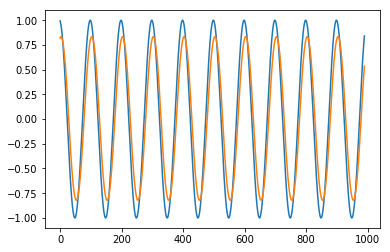

In [39]:
# Plot actuals vs. prediction
plot_actuals_to_predition(actuals, preds_ep1)

#### In the above plot we see that the predicted values are off from the actuals so we try to increase the epochs and see how the model performs


#### Run the the train and test for 5 epochs and same batch size

In [42]:
# Lets create another model to be run for 5 epochs
np_epochs = 5
batch_size = 512
model_ep5 = create_model()
hist_ep5 = train_model(model_ep5,train_X, train_y, np_epochs, batch_size)

C:\Users\apookalx\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(50, 1), return_sequences=True, units=50)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\apookalx\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 3564 samples, validate on 397 samples
Epoch 1/5
3564/3564 [==============================] - 25s 7ms/step - loss: 0.2761 - val_loss: 0.0907
Epoch 2/5
3564/3564 [==============================] - 24s 7ms/step - loss: 0.0528 - val_loss: 0.0070
Epoch 3/5
3564/3564 [==============================] - 23s 6ms/step - loss: 0.0173 - val_loss: 0.0038
Epoch 4/5
3564/3564 [==============================] - 25s 7ms/step - loss: 0.0153 - val_loss: 0.0037
Epoch 5/5
3564/3564 [==============================] - 24s 7ms/step - loss: 0.0134 - val_loss: 0.0037
> Train Time :  125.11809468269348


In [43]:
# Doing a prediction on the test data 
preds_ep5 = model_ep5.predict(test_X)

In [44]:
print("MSE of the prediction is: ",mean_squared_error(actuals,preds_ep5))

MSE of the prediction is:  0.00354650208497


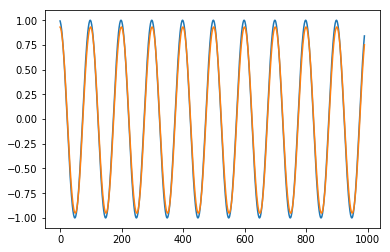

In [45]:
# Plot actuals vs. prediction
plot_actuals_to_predition(actuals, preds_ep5)

#### In the above plot the model prediction is quite close to the actuals

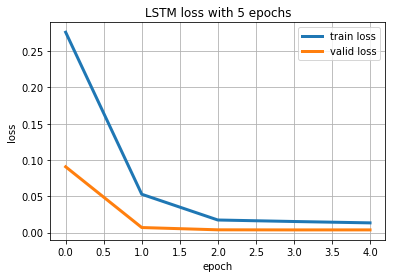

In [47]:
# Plot the loss graphs and see the behavior
plot_error_graph(hist_ep5, 'LSTM loss with 5 epochs')

### Run the the train and test for 10 epochs

In [48]:
# Lets create another model to be run for 5 epochs
np_epochs = 10
batch_size = 512
model_ep10 = create_model()
hist_ep10 = train_model(model_ep10,train_X, train_y, np_epochs, batch_size)

C:\Users\apookalx\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(50, 1), return_sequences=True, units=50)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\apookalx\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 3564 samples, validate on 397 samples
Epoch 1/10
3564/3564 [==============================] - 23s 6ms/step - loss: 0.2536 - val_loss: 0.0719
Epoch 2/10
3564/3564 [==============================] - 19s 5ms/step - loss: 0.0447 - val_loss: 0.0041
Epoch 3/10
3564/3564 [==============================] - 19s 5ms/step - loss: 0.0198 - val_loss: 0.0029
Epoch 4/10
3564/3564 [==============================] - 20s 6ms/step - loss: 0.0158 - val_loss: 0.0045
Epoch 5/10
3564/3564 [==============================] - 20s 6ms/step - loss: 0.0142 - val_loss: 0.0032
Epoch 6/10
3564/3564 [==============================] - 19s 5ms/step - loss: 0.0130 - val_loss: 5.2400e-04
Epoch 7/10
3564/3564 [==============================] - 19s 5ms/step - loss: 0.0107 - val_loss: 2.4662e-04
Epoch 8/10
3564/3564 [==============================] - 18s 5ms/step - loss: 0.0091 - val_loss: 4.7949e-04
Epoch 9/10
3564/3564 [==============================] - 20s 6ms/step - loss: 0.0083 - val_loss: 5.2252e-04
Epoch 10/1

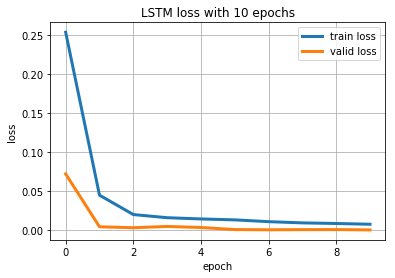

In [61]:
# Plot how the training & validation loss is progressing over each run
# observe here that the train and val loss kind of stabilizes after 6 epochs 
# we can say that the model is not learning more after the 8 epoch
plot_error_graph(hist_ep10, 'LSTM loss with 10 epochs')

In [53]:
# Doing a prediction on the test data 
preds_ep10 = model_ep10.predict(test_X)


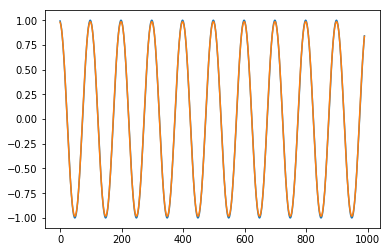

In [54]:
# Plot actuals vs. prediction
plot_actuals_to_predition(actuals, preds_ep10)

#### The above plot show that the predictions are near perfect as we ar not able to differentiate the actual and predicted plots

###  

In [58]:
# This is a generic function to set the window size which will move forward.

def moving_test_window_preds(model, n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [test_X[0,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(n_future_preds):
        # Note that this is already a scaled prediction so no need to rescale this
        preds_one_step = model.predict(moving_test_window) 
        # get the value from the numpy 2D array and append to predictions
        preds_moving.append(preds_one_step[0,0]) 
        # Reshaping the prediction to 3D array for concatenation with moving test window
        preds_one_step = preds_one_step.reshape(1,1,1)
        # This is the new moving test window, where the first element from the window has been removed and 
        # the prediction  has been appended to the end
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) 
    
   
    #a_preds_moving = np.array(preds_moving).reshape(-1,1)
    #print("preds_moving ", preds_moving)
    #preds_moving = scaler.inverse_transform(preds_moving)
    #a_preds_moving = scaler.inverse_transform(a_preds_moving)
    
    return preds_moving


In [59]:
# Now predict the sequence by using a window size of 500 that is we use 500 observations to predict the next. 
# Here we use the previously trained models (which ran for 10 epochs) as the model

window_size = 500 
preds_moving = moving_test_window_preds(model_ep10,window_size)

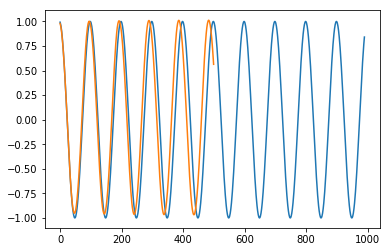

In [60]:
# Plot actuals vs. prediction
plot_actuals_to_predition(actuals, preds_moving)